In [1]:
%config Completer.use_jedi = False
%load_ext autoreload
%autoreload 2

In [2]:
import csv
import pandas as pd
import numpy as np
from PIL import Image
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import pickle

import torch
import hydra
import omegaconf
import pyrootutils
from tqdm import tqdm
from glob import glob

import matplotlib.pyplot as plt
from fgvc.data.plant_clef_data import PlantCLEFDataset

### Setup Training Data

In [3]:
df = pd.read_csv("/home/ubuntu/FGVC11/data/PlantClef/PlantCLEF2024singleplanttrainingdata.csv", delimiter=';')

/tmp/ipykernel_761167/3844927177.py:1: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/home/ubuntu/FGVC11/data/PlantClef/PlantCLEF2024singleplanttrainingdata.csv", delimiter=';')


In [4]:
df.head()

,image_name,organ,species_id,obs_id,license,partner,author,altitude,latitude,longitude,gbif_species_id,species,genus,family,dataset,publisher,references,url,learn_tag,image_backup_url
0,59feabe1c98f06e7f819f73c8246bd8f1a89556b.jpg,leaf,1396710,1008726402,cc-by-sa,NaN,Gulyás Bálint,205.9261,47.592160,19.362895,5284517.0,Taxus baccata L.,Taxus,Taxaceae,plantnet,plantnet,https://identify.plantnet.org/fr/k-southwester...,https://bs.plantnet.org/image/o/59feabe1c98f06...,train,https://lab.plantnet.org/LifeCLEF/PlantCLEF202...
1,dc273995a89827437d447f29a52ccac86f65476e.jpg,leaf,1396710,1008724195,cc-by-sa,NaN,vadim sigaud,323.7520,47.906703,7.201746,5284517.0,Taxus baccata L.,Taxus,Taxaceae,plantnet,plantnet,https://identify.plantnet.org/fr/k-southwester...,https://bs.plantnet.org/image/o/dc273995a89827...,train,https://lab.plantnet.org/LifeCLEF/PlantCLEF202...
2,416235e7023a4bd1513edf036b6097efc693a304.jpg,leaf,1396710,1008721908,cc-by-sa,NaN,fil escande,101.3160,48.826774,2.352774,5284517.0,Taxus baccata L.,Taxus,Taxaceae,plantnet,plantnet,https://identify.plantnet.org/fr/k-southwester...,https://bs.plantnet.org/image/o/416235e7023a4b...,train,https://lab.plantnet.org/LifeCLEF/PlantCLEF202...
3,cbd18fade82c46a5c725f1f3d982174895158afc.jpg,leaf,1396710,1008699177,cc-by-sa,NaN,Desiree Verver,5.1070,52.190427,6.009677,5284517.0,Taxus baccata L.,Taxus,Taxaceae,plantnet,plantnet,https://identify.plantnet.org/fr/k-southwester...,https://bs.plantnet.org/image/o/cbd18fade82c46...,train,https://lab.plantnet.org/LifeCLEF/PlantCLEF202...
4,f82c8c6d570287ebed8407cefcfcb2a51eaaf56e.jpg,leaf,1396710,1008683100,cc-by-sa,NaN,branebrane,165.3390,45.794739,15.965862,5284517.0,Taxus baccata L.,Taxus,Taxaceae,plantnet,plantnet,https://identify.plantnet.org/fr/k-southwester...,https://bs.plantnet.org/image/o/f82c8c6d570287...,train,https://lab.plantnet.org/LifeCLEF/PlantCLEF202...


In [5]:
# df["path"] = "/home/ubuntu/FGVC11/data/PlantClef/images_train/PlantCLEF2024/" + df.learn_tag + "/" + df.species_id.astype(str) + "/" + df.image_name
# df.to_csv("/home/ubuntu/FGVC11/data/PlantClef/PlantCLEFTrainHQ.csv", sep=';', index=False, quoting=csv.QUOTE_NONE, escapechar='/')

# df["path"] = "/home/ubuntu/FGVC11/data/PlantClef/images_train/images_max_side_800/" + df.species_id.astype(str) + "/" + df.image_name
# df.to_csv("/home/ubuntu/FGVC11/data/PlantClef/PlantCLEFTrainLQ.csv", sep=';', index=False, quoting=csv.QUOTE_NONE, escapechar='/')

### One Hot Encoder

In [ ]:
# build a one hot encoder
y = df['species_id'].values.reshape(-1, 1)
le = OneHotEncoder()
y_trf = le.fit_transform(y)

In [ ]:
# check the encoder
i = 10
print(y_trf[i].toarray())
print(y[i], le.inverse_transform(y_trf[i].toarray()))

In [ ]:
# save the decoder
with open("/home/ubuntu/FGVC11/data/PlantClef/le.pkl", "wb") as f: 
    pickle.dump(le, f)

In [ ]:
y = df['species_id'].values
# load and check teh decoder
with open("/home/ubuntu/FGVC11/data/PlantClef/le.pkl", "rb") as f: 
    le = pickle.load(f)
i = 10000
y_trf = le.transform(y.reshape(-1, 1))
print(y[i], le.inverse_transform(y_trf[i].toarray()))

### Test Dataset Class

In [6]:
cfg = omegaconf.OmegaConf.load("/home/ubuntu/FGVC11/configs/data/plant_clef_data.yaml")
datamodule = hydra.utils.instantiate(cfg)
datamodule.setup()

/home/ubuntu/FGVC11/src/fgvc/data/plant_clef_data.py:94: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  self.df = pd.read_csv(df_train, delimiter=";", escapechar="/")


In [ ]:
for batch in datamodule.train_dataloader():
    # print(batch)
    break

In [ ]:
plt.imshow(batch["image"][0].permute(1, 2, 0))

In [ ]:
batch["label"][0]

In [ ]:
batch["encoded_label"][0]

In [ ]:
# load and check the decoder
with open("/home/ubuntu/FGVC11/data/PlantClef/le.pkl", "rb") as f: 
    le = pickle.load(f)
i = 10
print(batch["label"][i], le.inverse_transform(batch["encoded_label"])[i])

### Test model Class

In [7]:
cfg = omegaconf.OmegaConf.load("/home/ubuntu/FGVC11/configs/model/plant_clef_model.yaml")
model = hydra.utils.instantiate(cfg)

/home/ubuntu/miniconda3/envs/transformers/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:196: UserWarning: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
  rank_zero_warn(
/home/ubuntu/miniconda3/envs/transformers/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:196: UserWarning: Attribute 'criterian' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['criterian'])`.
  rank_zero_warn(


### Run Submission

In [8]:
submission_df = pd.DataFrame(columns=["path", "plot_id", "species_ids"])
submission_df["path"] = glob("/home/ubuntu/FGVC11/data/PlantClef/images/*.jpg")
submission_df["plot_id"] = submission_df["path"].apply(lambda x: x.split("/")[-1].split(".")[0])

In [9]:
test_ds = PlantCLEFDataset(
    df=submission_df,
    transform=datamodule.test_transform,
    label_encoder=datamodule.le,
    return_image=True,
    return_labels=False,
    return_metadata=False, 
    )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


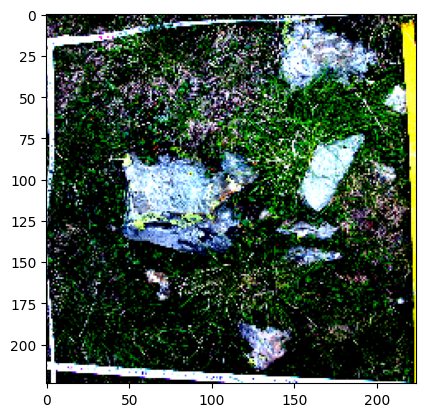

In [10]:
plt.imshow(test_ds[0]["image"].permute(1, 2, 0))

In [11]:
test_dl = torch.utils.data.DataLoader(
    dataset=test_ds,
    batch_size=64,
    shuffle=False,
    num_workers=8,
    pin_memory=True,
    persistent_workers=True,
)

In [12]:
model.to("cuda");
model.eval();

In [30]:
for batch in tqdm(datamodule.test_dataloader()):
    break

  0%|          | 0/2997 [00:00<?, ?it/s]


In [34]:
batch["encoded_label"].shape

torch.Size([16, 7806])

In [41]:
cats = datamodule.le.categories_[0]
test_targets = []
test_preds = []
for batch in tqdm(datamodule.test_dataloader()):
    image = batch["image"].to("cuda")
    test_targets.append(batch["encoded_label"].cpu().numpy())
    with torch.no_grad():
        output = model(image)
    test_preds.append(output.cpu().numpy())

  0%|          | 0/2997 [00:00<?, ?it/s]

100%|██████████| 2997/2997 [01:15<00:00, 39.70it/s]


In [42]:
test_targets = np.concatenate(test_targets, axis=0)
test_preds = np.concatenate(test_preds, axis=0)

In [43]:
test_preds.shape, test_targets.shape

((47940, 7806), (47940, 7806))

In [48]:
from sklearn.metrics import f1_score

In [ ]:
thresh = []
for i in range(test_targets.shape[0]):
    tgt = test_targets[:, i]
    prd = test_preds[:, i]
    # get the best threshold between 0 and 1 based on the f1 score
    f1 = []
    for t in np.linspace(0, 1, 11):
        f1.append(f1_score(tgt, prd > t))
    # print(np.linspace(0, 1, 10)[np.argmax(f1)], f1[np.argmax(f1)])
    thresh.append(np.linspace(0, 1, 10)[np.argmax(f1)])
    # break

In [113]:
thresh = [i if i > 0.6 else 0.6 for i in thresh]


In [114]:
thresh = np.array(thresh)

(array([6910.,    0.,    0.,  888.,    0.,    0.,    0.,    0.,    0.,
           8.]),
 array([0.6       , 0.61777778, 0.63555556, 0.65333333, 0.67111111,
        0.68888889, 0.70666667, 0.72444444, 0.74222222, 0.76      ,
        0.77777778]),
 <BarContainer object of 10 artists>)

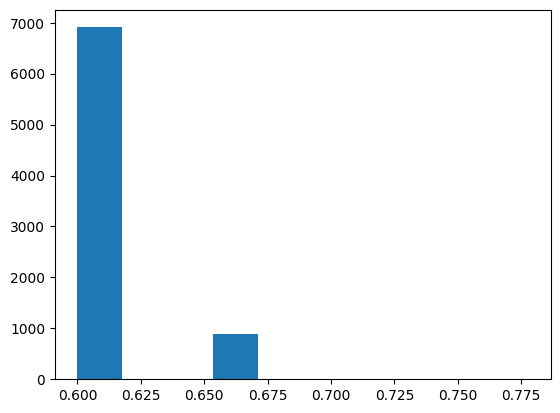

In [115]:
plt.hist(thresh)

In [117]:
cats = datamodule.le.categories_[0]
test_labels = []
for batch in tqdm(test_dl):
    image = batch["image"].to("cuda")
    with torch.no_grad():
        output = model(image)
    # break
    out = (output.cpu().numpy() > thresh)
    for obj in (out):
        test_labels.append(str(list(cats[obj])))
    # break

  0%|          | 0/27 [00:00<?, ?it/s]

100%|██████████| 27/27 [01:19<00:00,  2.96s/it]


In [118]:
submission_df["species_ids"] = test_labels
submission_df[["plot_id", "species_ids"]].to_csv("my_run.csv", sep=';', index=False, quoting=csv.QUOTE_NONE)